In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = 'localhost',
                            username = 'root',
                            password = 'Kautilya@6201',
                            database = 'ecommerce')

cur = db.cursor()


# List all unique cities where customers are located.

In [5]:
query = """ select distinct customer_city from customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [6]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()

'total orders placed in 2017 are', data[0][0]

('total orders placed in 2017 are', 45101)

# Find the total sales per category.

In [12]:
query = """ select upper(products.product_category) category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Category','Sales'])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments.

In [31]:
query = """ select sum(case when payment_installments >= 1 then 1
else 0 end)/count(*)*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

data

[(Decimal('99.9981'),)]

# Count the number of customers from each state. 

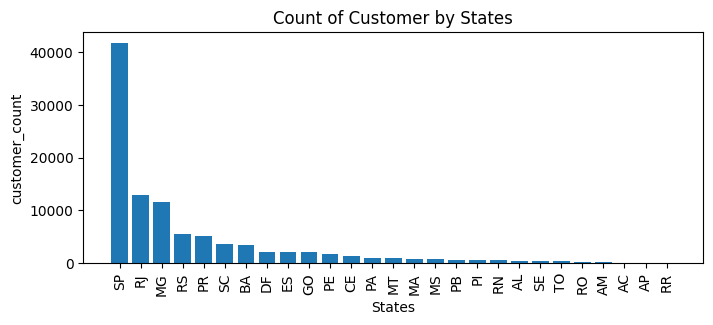

In [44]:
query = """ select customer_state,count(customer_id) 
from customers group by customer_state"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['state','customer_count'])
df = df.sort_values(by = 'customer_count',ascending=False) 
plt.figure(figsize = (8,3))
plt.bar(df['state'], df['customer_count'])
plt.xticks(rotation = 90)
plt.xlabel('States')
plt.ylabel('customer_count')
plt.title('Count of Customer by States)
plt.show()

# Calculate the number of orders per month in 2018.

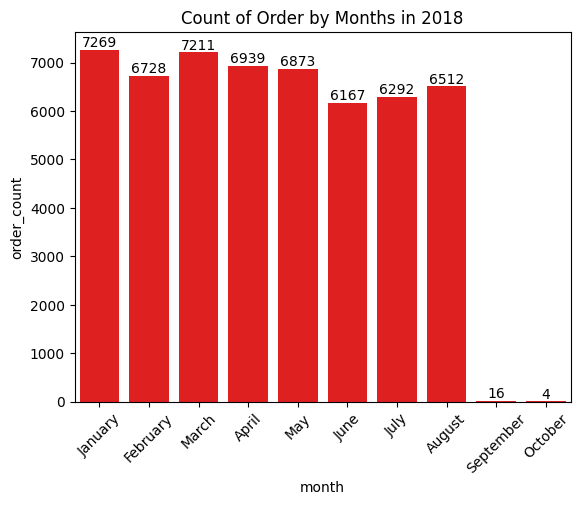

In [49]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['month','order_count'])
o = ['January','February','March','April','May','June','July','August','September','October']

ax = sns.barplot(x = df['month'], y = df['order_count'], data = df, order = o, color = 'red')
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title('Count of Order by Months in 2018')
plt.show()

# Find the average number of products per order, grouped by customer city.

In [58]:
query = """ with count_per_order as
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['customer_city','average orders'])
df.head(10)

,customer_city,average orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category.

In [9]:
query = """ select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Category','percentage distribution'])
df.head(10)

,Category,percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


# Identify the correlation between product price and the number of times a product has been purchased.


In [21]:
query = """ select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Category','order_count','price'])
df

arr1 = df['order_count']
arr2 = df['price']

a = np.corrcoef([arr1,arr2])
print('The correlation between price and number of times a product has been purchased is', a[0][1])

The correlation between price and number of times a product has been purchased is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

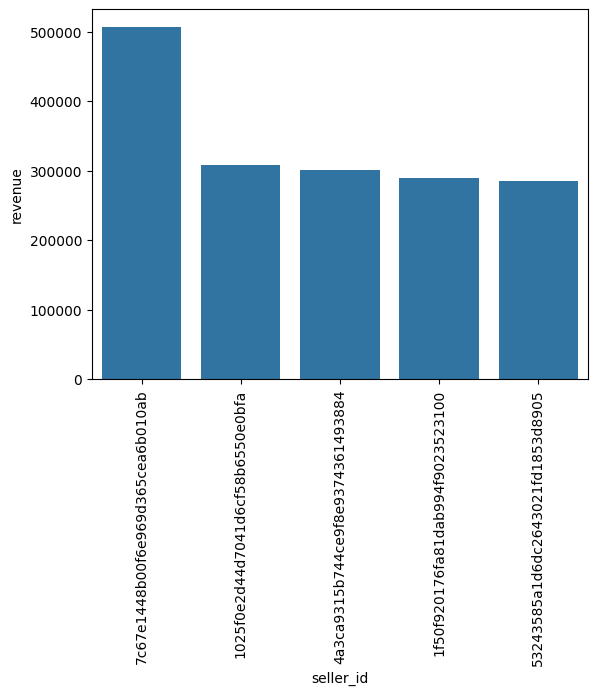

In [28]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['seller_id', 'revenue', 'rank'])
df = df.head()
sns.barplot(x = 'seller_id', y = 'revenue', data = df)
plt.xticks(rotation=90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [32]:
query = """ select customer_id, order_purchase_timestamp,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.010002
...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.500000


# Calculate the cumulative sales per month for each year.

In [37]:
query = """ select years, months, payment, sum(payment)
over(order by years, months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
monthname(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,December,19.62,19.62
1,2016,October,59090.48,59110.10
2,2016,September,252.24,59362.34
3,2017,April,417788.03,477150.37
4,2017,August,674396.32,1151546.69
5,2017,December,878401.48,2029948.17
6,2017,February,291908.01,2321856.18
7,2017,January,138488.04,2460344.22
8,2017,July,592382.92,3052727.14
9,2017,June,511276.38,3564003.52


# Calculate the year-over-year growth rate of total sales.

In [42]:
 query = """ with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, (payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)*100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['year','yoy % growth'])
df

,year,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [51]:
 query = """ with a as (select customers.customer_id,
 min(orders.order_purchase_timestamp) first_order
 from customers join orders
 on customers.customer_id = orders.customer_id
 group by customers.customer_id)
 
select a.customer_id, count(distinct orders.order_purchase_timestamp)
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id"""

cur.execute(query)
data = cur.fetchall()
data

[]

# Identify the top 3 customers who spent the most money in each year.

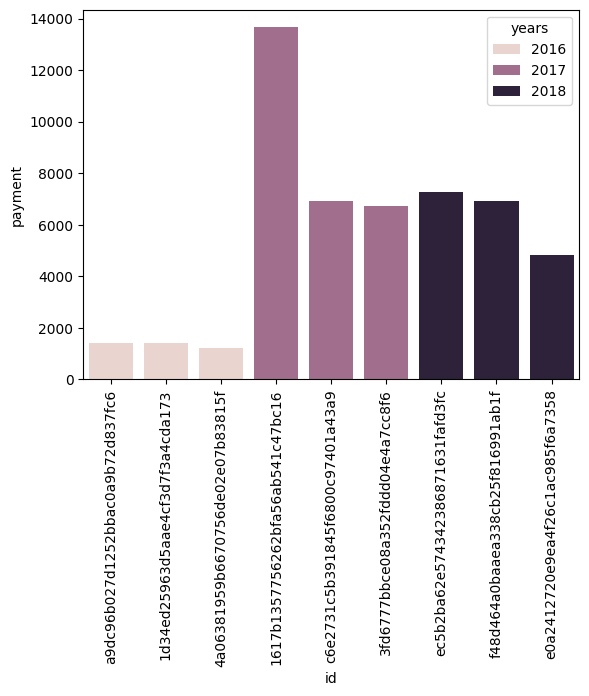

In [62]:
 query = """ select years, customer_id, payment, d_rank from
 (select year(orders.order_purchase_timestamp) years,
 orders.customer_id,
 sum(payments.payment_value) payment,
 dense_rank() over(partition by year(orders.order_purchase_timestamp)
 order by sum(payments.payment_value) desc) d_rank
 from orders join payments
 on payments.order_id = orders.order_id
 group by year(orders.order_purchase_timestamp),
 orders.customer_id) as a
 where d_rank <= 3"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['years','id','payment','rank'])
sns.barplot(x = 'id', y = 'payment', data = df, hue = 'years')
plt.xticks(rotation = 90)
plt.show()